# Fig11. SEEPS (total precipitation)

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.0
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Data

In [6]:
ds_static = xr.open_zarr(conf['geo']['geo_file_zarr'])
grid_lat = ds_static['lat2d'].values
grid_lon = ds_static['lon2d'].values

In [7]:
# RMSE line graph
load_name = conf['data']['save_loc'] + 'SEEPS_line_graph.npy'
SEEPS_lines = np.load(load_name, allow_pickle=True)[()]

In [8]:
fn_ERA5 = '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/TP_stats_120h_ERA5.nc'
ds_ERA5 = xr.open_dataset(fn_ERA5)

fn_IFS = '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/TP_stats_120h_IFS.nc'
ds_IFS = xr.open_dataset(fn_IFS)

fn_fuxi_dry = '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/fuxi_plevel_dry/TP_stats_120h_fuxi_dry.nc'
ds_dry = xr.open_dataset(fn_fuxi_dry)

fn_fuxi_physics = '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/fuxi_plevel_physics/TP_stats_120h_fuxi_physics.nc'
ds_physics = xr.open_dataset(fn_fuxi_physics)

In [9]:
dict_stats = {}
dict_stats['IFS_mean'] = ds_IFS['mean'].values
dict_stats['IFS_std'] = ds_IFS['std'].values
dict_stats['IFS_p95'] = ds_IFS['p95'].values

dict_stats['ERA5_mean'] = ds_ERA5['mean'].values
dict_stats['ERA5_std'] = ds_ERA5['std'].values
dict_stats['ERA5_p95'] = ds_ERA5['p95'].values

dict_stats['fuxi_dry_mean'] = ds_dry['mean'].values
dict_stats['fuxi_dry_std'] = ds_dry['std'].values
dict_stats['fuxi_dry_p95'] = ds_dry['p95'].values

dict_stats['fuxi_physics_mean'] = ds_physics['mean'].values
dict_stats['fuxi_physics_std'] = ds_physics['std'].values
dict_stats['fuxi_physics_p95'] = ds_physics['p95'].values

## Plot

In [10]:
grid_shape = grid_lat.shape
my_colors = gu.ksha_color_set_summon(color_set=0)

red = my_colors['red']
blue = my_colors['blue']
orange = my_colors['orange']

In [11]:
def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.1, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False

    ax.add_feature(cfeature.COASTLINE.with_scale('110m'), edgecolor='k', linewidth=0.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [12]:
# line specs
line_keys = {}
line_keys['IFS'] = {'linewidth': 3, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 3, 'label': ''}
line_keys['fuxi_dry'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['fuxi_physics'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}

# lead time settings
LEADs = np.arange(24, 240+24, 24)
N_leads = len(LEADs)
LEAD_ticks = LEADs

# legend names
legend_labels_rmse = [
    'IFS', 'FuXi-base', 'FuXi-physics'
]

# colormap
#CMAP, _ = gu.precip_cmap(return_rgb=True, land_map=False)
CMAP = plt.cm.nipy_spectral_r #cmaps.hotcolr_19lev

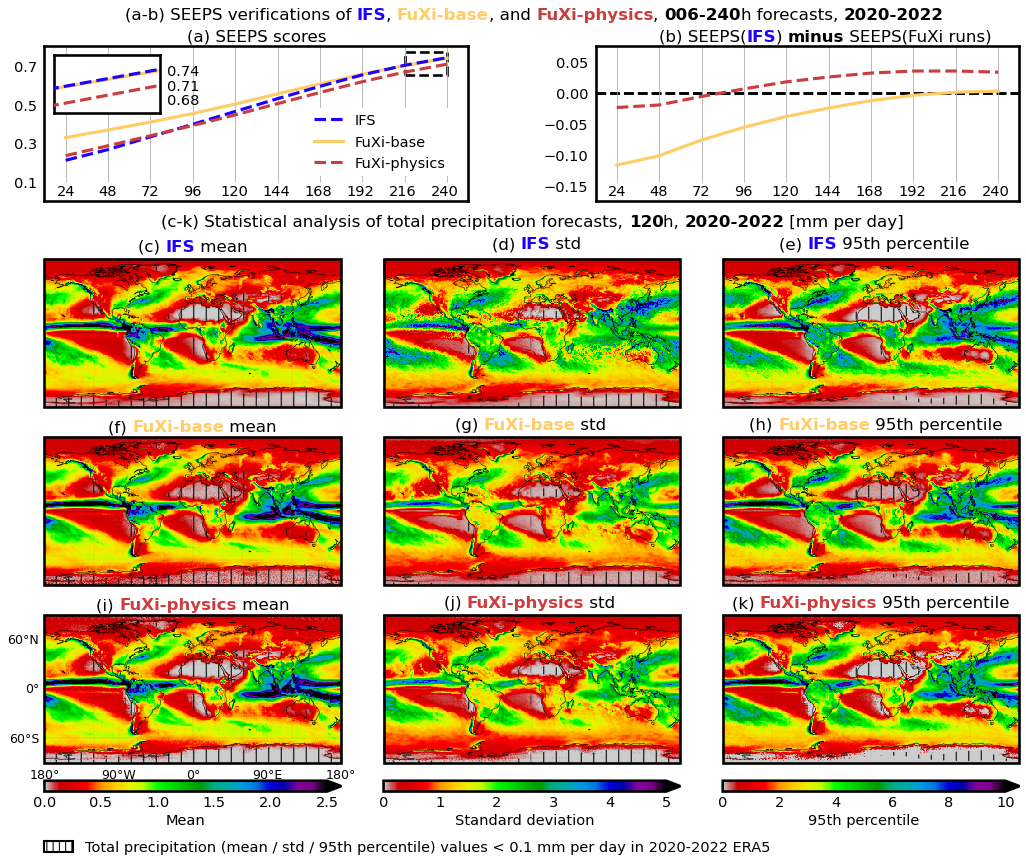

In [13]:
handles = []
proj_ = ccrs.PlateCarree(central_longitude=0.0)

fig = plt.figure(figsize=(13, 9.6), dpi=dpi_)
gs = gridspec.GridSpec(8, 23, 
                       height_ratios=[1, 0.175, 0.175, 1, 0.15, 1, 0.15, 1], 
                       width_ratios=[1,]*23)

AX_lines = []
AX_lines.append(plt.subplot(gs[0, 0:10]))
AX_lines.append(plt.subplot(gs[0, 13:23]))

ax_title1 = plt.subplot(gs[1, :])
ax_title2 = [plt.subplot(gs[2, 0:7]), plt.subplot(gs[4, 0:7]), plt.subplot(gs[6, 0:7])]
ax_title4 = [plt.subplot(gs[2, 8:15]), plt.subplot(gs[4, 8:15]), plt.subplot(gs[6, 8:15])]
ax_title6 = [plt.subplot(gs[2, 16:23]), plt.subplot(gs[4, 16:23]), plt.subplot(gs[6, 16:23])]

AX_map0 = []
AX_map1 = []
AX_map2 = []

AX_map0.append(plt.subplot(gs[3, 0:7], projection=proj_))
AX_map0.append(plt.subplot(gs[5, 0:7], projection=proj_))
AX_map0.append(plt.subplot(gs[7, 0:7], projection=proj_))

AX_map1.append(plt.subplot(gs[3, 8:15], projection=proj_))
AX_map1.append(plt.subplot(gs[5, 8:15], projection=proj_))
AX_map1.append(plt.subplot(gs[7, 8:15], projection=proj_))

AX_map2.append(plt.subplot(gs[3, 16:23], projection=proj_))
AX_map2.append(plt.subplot(gs[5, 16:23], projection=proj_))
AX_map2.append(plt.subplot(gs[7, 16:23], projection=proj_))

AX_maps = AX_map0 + AX_map1 + AX_map2

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)
#plt.tight_layout()

for ax in AX_maps:
    ax = map_gridline_opt(ax)

GL = AX_map0[2].gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color='k', linewidth=0.1, linestyle=':', zorder=5
)

GL.top_labels = None #GL.bottom_labels = None
GL.right_labels = None #GL.left_labels = None
GL.xlabel_style = {'size': 12}; GL.ylabel_style = {'size': 12}
GL.xlocator = ticker.FixedLocator([-180, -90, 0, 90, 180])
GL.ylocator = ticker.FixedLocator([-60, 0, 60])

for ax in AX_lines:
    ax = gu.ax_decorate_box(ax)
    # tick param config
    ax.tick_params(labelleft=True, labelsize=14)
    
    ax.set_xticks(LEAD_ticks)
    ax.set_xlim([LEAD_ticks[0]-12, LEAD_ticks[-1]+12])
    
    ax.xaxis.grid(False)
    ax.grid(':', axis='x')

y_loc = 0.02
x_locs = np.linspace(0.05, 0.945, len(LEAD_ticks))
for i_ax, ax in enumerate(AX_lines):
    for i_lead, lead in enumerate(LEAD_ticks):
        ax.text(
            x_locs[i_lead], y_loc, str(int(lead)), ha='center', va='bottom', fontsize=14,
            bbox=dict(facecolor='white', linewidth=0, boxstyle='round,pad=0.1'),
            transform=ax.transAxes
        )
        
# ================================================================= #
# line graph
factors = 1
y_lims = [0.0, 0.8]
y_ticks = [0.1, 0.3, 0.5, 0.7]
y_lims_zoom = [0.65, 0.77]
y_lims_ticks = [0.68, 0.71, 0.74]

# zoom-in
axins = zoomed_inset_axes(
    AX_lines[0], 2.5, 
    bbox_to_anchor=(0.285, 0.975), 
    bbox_transform=AX_lines[0].transAxes
)
axins.set_xlim([LEADs[-2], LEADs[-1]])
axins.set_ylim(y_lims_zoom)
axins = gu.ax_decorate_box(axins)
axins.tick_params(labelright=True, labelsize=14)
axins.set_yticks(y_lims_ticks)

coords = (
    LEADs[-2], 
    y_lims_zoom[0], 
    LEADs[-1]-LEADs[-2], 
    y_lims_zoom[1]-y_lims_zoom[0]
) # (x, y, width, height)

rect = Rectangle(
    (coords[0], coords[1]), coords[2], coords[3], 
    edgecolor='k', facecolor='none', linewidth=2.5, linestyle='--'
)

AX_lines[0].add_patch(rect)

for model_name in ['IFS', 'fuxi_dry', 'fuxi_physics']:
    seeps_ = SEEPS_lines['{}_total_precipitation'.format(model_name)][:N_leads] * factors
    AX_lines[0].plot(LEADs, seeps_, **line_keys[model_name])
    AX_lines[0].set_ylim(y_lims)
    AX_lines[0].set_yticks(y_ticks)
    axins.plot(LEADs, seeps_, **line_keys[model_name])


# ================================================================= #
# bar graph
factors = 1
y_lims = [-0.175, 0.075]
y_ticks = [-0.15, -0.1, -0.05, 0, 0.05]

# RMSE(IFS)
seeps_IFS = SEEPS_lines['IFS_total_precipitation'][:N_leads] * factors

for i_model, model_name in enumerate(['fuxi_dry', 'fuxi_physics']):
    # diff
    seeps_ = SEEPS_lines['{}_total_precipitation'.format(model_name)][:N_leads] * factors
    diff_ = seeps_IFS - seeps_
    AX_lines[1].plot(LEADs, diff_, **line_keys[model_name])
    AX_lines[1].axhline(y=0, color='k', linestyle='--', linewidth=2.5, zorder=0)
    AX_lines[1].set_ylim(y_lims)
    AX_lines[1].set_yticks(y_ticks)

# # ================================================================= #
# stats
y_lims0 = [0, 2.5]
y_lims1 = [0, 5]
y_lims2 = [0, 10]

mean_ERA5 = 1e3*dict_stats['ERA5_mean']
std_ERA5 = 1e3*dict_stats['ERA5_std']
p95_ERA5 = 1e3*dict_stats['ERA5_p95']

for i_model, model_name in enumerate(['IFS', 'fuxi_dry', 'fuxi_physics']):
    mean_ = 1e3*dict_stats['{}_mean'.format(model_name)]
    std_ = 1e3*dict_stats['{}_std'.format(model_name)]
    p95_ = 1e3*dict_stats['{}_p95'.format(model_name)]
    
    CS1 = AX_map0[i_model].pcolormesh(
        grid_lon, grid_lat, mean_,
        vmin=y_lims0[0], vmax=y_lims0[1],
        cmap=CMAP, transform=ccrs.PlateCarree()
    )

    AX_map0[i_model].contourf(
        grid_lon, grid_lat, mean_ERA5,
        levels=(0, 0.1), colors=('none',),
        hatches=('|',), transform=ccrs.PlateCarree()
    )
    
    CS2 = AX_map1[i_model].pcolormesh(
        grid_lon, grid_lat, std_,
        vmin=y_lims1[0], vmax=y_lims1[1],
        cmap=CMAP, transform=ccrs.PlateCarree()
    )

    AX_map1[i_model].contourf(
        grid_lon, grid_lat, std_ERA5,
        levels=(0, 0.1), colors=('none',),
        hatches=('|',), transform=ccrs.PlateCarree()
    )
    
    CS3 = AX_map2[i_model].pcolormesh(
        grid_lon, grid_lat, p95_,
        vmin=y_lims2[0], vmax=y_lims2[1],
        cmap=CMAP, transform=ccrs.PlateCarree()
    )

    AX_map2[i_model].contourf(
        grid_lon, grid_lat, p95_ERA5,
        levels=(0, 0.1), colors=('none',),
        hatches=('|',), transform=ccrs.PlateCarree()
    )
    
# ================================================================= #
# colorbars
CS_list = [CS1, CS2, CS3]
w_ = np.sum([7, 1, 7, 1, 7])

x_loc = [0, 8/w_, 16/w_]
CBar_labels = ['Mean', 'Standard deviation', '95th percentile']
for i in range(3):
    ax_base = fig.add_axes([x_loc[i], -0.05, 7/w_, 0.03])
    [j.set_linewidth(1.0) for j in ax_base.spines.values()]
    ax_base.set_axis_off()
    ax_base.tick_params(
        axis='both', left=False, top=False, right=False, bottom=False, 
        labelleft=False, labeltop=False, labelright=False, labelbottom=False
    )
    cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
    CBar = plt.colorbar(CS_list[i], orientation='horizontal', extend='max', cax=cax)
    CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
    CBar.outline.set_linewidth(2.5)
    CBar.set_label(CBar_labels[i], fontsize=14)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['IFS']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_dry']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_physics']))

ax_lg1 = fig.add_axes([0.25, 0.805, 0.175, 0.12])
LG1 = ax_lg1.legend(handle_legneds1, ['IFS', 'FuXi-base', 'FuXi-physics'], 
                    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})

handle_legneds4 = []

handle_legneds4.append(
    patches.Patch(facecolor='w', 
                  edgecolor='k', 
                  linewidth=2.0, 
                  hatch='||', 
                  label=' ')
)

ax_lg4 = fig.add_axes([0, -0.125, 0.758, 0.04])
LG4 = ax_lg4.legend(
    handle_legneds4, 
    [
        'Total precipitation (mean / std / 95th percentile) values < 0.1 mm per day in 2020-2022 ERA5',
    ], 
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}
)
# ================================================================= #
# Overall titles
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold']*5

ax_title0 = [
    fig.add_axes([0.0, 1.03, 1.0, 0.025]),
    fig.add_axes([0.0, 1.00, 10/23, 0.03]),
    fig.add_axes([13/23, 1.00, 10/23, 0.03])
]
    
title_len = 0.835
handles += gu.string_partial_format(
    fig, ax_title0[0], 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(a-b) SEEPS verifications of ',
        'IFS',
        ', ',
        'FuXi-base',
        ', and ',
        'FuXi-physics',
        ', ',
        '006-240',
        'h forecasts, ', 
        '2020-2022',
    ], 
    ['k', blue, 'k', orange, 'k', red, 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title0[1].text(
    0.5, 0.8, '(a) SEEPS scores', 
    ha='center', va='top', fontsize=16, transform=ax_title0[1].transAxes
)

title_len = 0.7
handles += gu.string_partial_format(
    fig, ax_title0[2], 0.5*(1-title_len), 0.8, 'left', 'top', 
    [
        '(b) SEEPS(',
        'IFS',
        ') ',
        'minus',
        ' SEEPS(FuXi runs)',
    ], 
    ['k', blue, 'k', 'k', 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

title_len = 0.76
handles += gu.string_partial_format(
    fig, ax_title1, 0.5*(1-title_len), 0.5, 'left', 'top', 
    [
        '(c-k) Statistical analysis of total precipitation forecasts, ',
        '120',
        'h, ',
        '2020-2022',
        ' [mm per day]'
    ], 
    ['k', 'k', 'k', 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

# # ================================================================= #
# # titles on each panel
model_names = ['IFS', 'FuXi-base', 'FuXi-physics']
model_colors = [blue, orange, red]

title_label = ['(c)', '(f)', '(i)']
title_lens = [0.37, 0.57, 0.65]
for i in range(3):
    ax = ax_title2[i]
    color_ = model_colors[i]
    handles += gu.string_partial_format(
        fig, ax, 0.5*(1-title_lens[i]), 0.6, 'left', 'top', 
        [
            f'{title_label[i]} ', f'{model_names[i]}',' mean',
        ], 
        ['k', color_, 'k'], 
        fontsize_list, 
        fontweight_list
    )

title_label = ['(d)', '(g)', '(j)']
title_lens = [0.37-0.1, 0.57-0.05, 0.65-0.055]
for i in range(3):
    ax = ax_title4[i]
    color_ = model_colors[i]
    handles += gu.string_partial_format(
        fig, ax, 0.5*(1-title_lens[i]), 0.7, 'left', 'top', 
        [
            f'{title_label[i]} ', f'{model_names[i]}',' std',
        ], 
        ['k', color_, 'k'], 
        fontsize_list, 
        fontweight_list
    )

title_label = ['(e)', '(h)', '(k)']
title_lens = [0.37+0.25, 0.57+0.25, 0.65+0.29]
for i in range(3):
    ax = ax_title6[i]
    color_ = model_colors[i]
    handles += gu.string_partial_format(
        fig, ax, 0.5*(1-title_lens[i]), 0.7, 'left', 'top', 
        [
            f'{title_label[i]} ', f'{model_names[i]}',' 95th percentile',
        ], 
        ['k', color_, 'k'], 
        fontsize_list, 
        fontweight_list
    )

for ax in (ax_title0 + ax_title2 + ax_title4 + ax_title6):
    ax.set_axis_off()

ax_title1.set_axis_off()
LG1 = gu.lg_box(LG1)
LG4 = gu.lg_box(LG4)
ax_lg1.set_axis_off()
ax_lg4.set_axis_off()